# ------------- Logistics -------------

In [1]:
from __future__ import division
import numpy
import os
import pandas
import sklearn
import sys
import sqlite3
import pickle
from operator import itemgetter
from collections import Counter
import itertools
import matplotlib
import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, scale, LabelEncoder
from sklearn import model_selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV



#------------- Custom functions -------------#

def plot_recall(classifier_name, cm, output_directory):
    
    #---Plot settings ---#
    fig, ax = plt.subplots()

    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)

    # Number of ticks in axes
    plt.yticks(numpy.arange(0.0, 1.05, 0.05))

    # Axes limit
    axes = ax.axes
    axes.set_ylim(0.0,1.05)    

    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.2)    

    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.15)   
    
    numpy.set_printoptions(precision=3, suppress=True)
    
    
    #---Plot data ---#    

    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]   
    cm_diag = normalized_cm.diagonal()    
        
    bar_labels = sorted(list(set(ground_truth)))
    y_pos = numpy.arange(len(bar_labels))

    plt.bar(y_pos,
        cm_diag,
        align='center',
        color='blue')

    plt.ylabel('Percent of cells correctly classifed (recall)')
    plt.xticks(y_pos, bar_labels, rotation='vertical')
    
    plt.title('Cell Classes, ' + classifier_name)
    plt_name = classifier_name + '_plot.png'
    plt.savefig(os.path.join(output_directory, plt_name))
    plt.show()
    plt.clf()
 
         
def plot_confusion_matrix(cm, output_directory, classifier_name, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues 
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    cm_file_name = name + '_cm.txt'
    cm_file = open(os.path.join(output_directory, cm_file_name), 'w+')
    cm_file.write(str(cm))
    cm_file.close()         
       
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt_name = classifier_name + '_confusion_matrix.png'
    plt.savefig(os.path.join(output_directory, plt_name))
    plt.show()
    plt.clf()


def variance_threshold_select(df, thresh=0.0, na_replacement=-999):
    df1 = df.copy(deep=True) # Make a deep copy of the dataframe
    selector = VarianceThreshold(thresh)
    selector.fit(df1.fillna(na_replacement)) # Fill NA values as VarianceThreshold cannot deal with those
    df2 = df.loc[:,selector.get_support(indices=False)] # Get new dataframe with columns deleted that have NA values
    return df2


def save_metadata(file, label_list):
    with open(file, 'w') as f:
        for i in label_list:
            f.write('{}\n'.format( i ))
            
            
def plot_rank_importance(data, labels, output_directory):
    
    model = RandomForestRegressor(n_estimators=20, max_features=2)
    model = model.fit(data, labels)
    model.feature_importances_      

    important_features = pandas.Series(data=model.feature_importances_, index=data.columns)
    important_features.sort_values(ascending=False,inplace=True)
    std = numpy.std([tree.feature_importances_ for tree in model.estimators_],axis=0)       

    # Plot the feature importances of the forest   
    plt.figure(figsize=(35, 20))
    
    plt.title("Feature importances")
    plt.bar(range(important_features.shape[0]), important_features, yerr = std, color="r", align="center")
    feature_names = list(important_features.index)
    plt.xticks(range(important_features.shape[0]), feature_names)
    plt.xticks(rotation=90)
    plt.xlim([-1, important_features.shape[0]])
    matplotlib.rcParams.update({'font.size': 10})
    
    plt_name = 'feature_ranking.png'
    plt.savefig(os.path.join(output_directory, plt_name))
    plt.show()
    plt.clf()

# ------------- User's settings -------------

In [2]:
#----- The dot "." means "current directory" -----#
train_directory = "./train_results" 
test_directory = "./test_results"

#----- Load CellProfiler output database -----#
database_train = sqlite3.connect('../CPOut/DefaultDB_train.db')
database_test = sqlite3.connect('../CPOut/DefaultDB_test.db')

#----- Define unwanted parameters -----#
not_wanted = [ "Number", "Location", "Center" ]


#----- Define the models to test. Multiple choices possible -----#

names_classifiers = []
names_classifiers.append(( 'NaiveBayes', GaussianNB() ) )
names_classifiers.append(( 'RandomForest', RandomForestClassifier() ) )
# names_classifiers.append(( 'KernelSVM', SVC() ) )
# names_classifiers.append(( 'LinearSVM', LinearSVC() ) )



#----- Logistic -----#
for directory in [train_directory, test_directory]:  
    if not os.path.exists(directory):
        os.makedirs(directory)

# ------------- Data loading and preprocessing -------------

In [ ]:
#----- Load training data -----#

query_objects = database_train.execute("SELECT * From Per_Object")
cols_objects = [column[0] for column in query_objects.description]
objects = pandas.DataFrame.from_records(data = query_objects.fetchall(), columns = cols_objects)

variables_object = [x for x in objects.columns.values if numpy.all([not z in x for z in not_wanted])]
objects_train = pandas.DataFrame(objects, columns=[variables_object + ["ImageNumber"]])
print('Original data has shape (rows, columns)              : ', objects_train.shape)

query_image = database_train.execute("SELECT * From Per_Image")
cols_image = [column[0] for column in query_image.description]
images = pandas.DataFrame.from_records(data = query_image.fetchall(), columns = cols_image)

variables_image = [col for col in images.columns if col.startswith(('ImageNumber','Image_Metadata_folder'))]
images_train = pandas.DataFrame(images, columns=variables_image)



#----- Remove any row that has NA -----#
objects_train = objects_train.dropna()
print('After removing NA rows, data has shape               : ', objects_train.shape)


#----- Create ground-truth label for each cells -----#
merged_table = pandas.merge(images_train, objects_train, on=['ImageNumber'], how='inner')
ground_truth = list(merged_table.Image_Metadata_folder)
# Save labels, to be used as "metadata" on http://projector.tensorflow.org
save_metadata( os.path.join(train_directory, 'ground_truth_labels.tsv'), ground_truth )


#----- Remove all zero-variance features -----#
# i.e. features that have the same value in all samples.
objects_train = variance_threshold_select(objects_train.drop([objects_train.columns[-1]], axis=1))
print('After removing zero-variance features, data has shape: ', objects_train.shape)


#----- Logistic for training data -----#
le = LabelEncoder()
le.fit(ground_truth)
numeric_labels = le.fit_transform(ground_truth)

----- Tree-based feature selection -----

When the dataset has two (or more) correlated features, 
then any of these correlated features can be used as the predictor.
For the computer, there's no concrete preference of one over the others. 

It makes sense to remove features that are mostly duplicated by other features (redundancy)
Tree-based feature selection will help us to (randomly) 
keep only one of them, and remove others.

This is not an issue when we want to use feature selection to reduce overfitting.
But when interpreting the data, it can lead to the incorrect conclusion that 
one of the variables is a strong predictor while the others in the same group are unimportant.

Read [more](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)

Original data has shape (rows, columns)              :  (6300, 483)
After removing NA rows, data has shape               :  (3363, 483)
After removing zero-variance features, data has shape:  (3363, 482)
After feature selection, data has shape              :  (3363, 219)


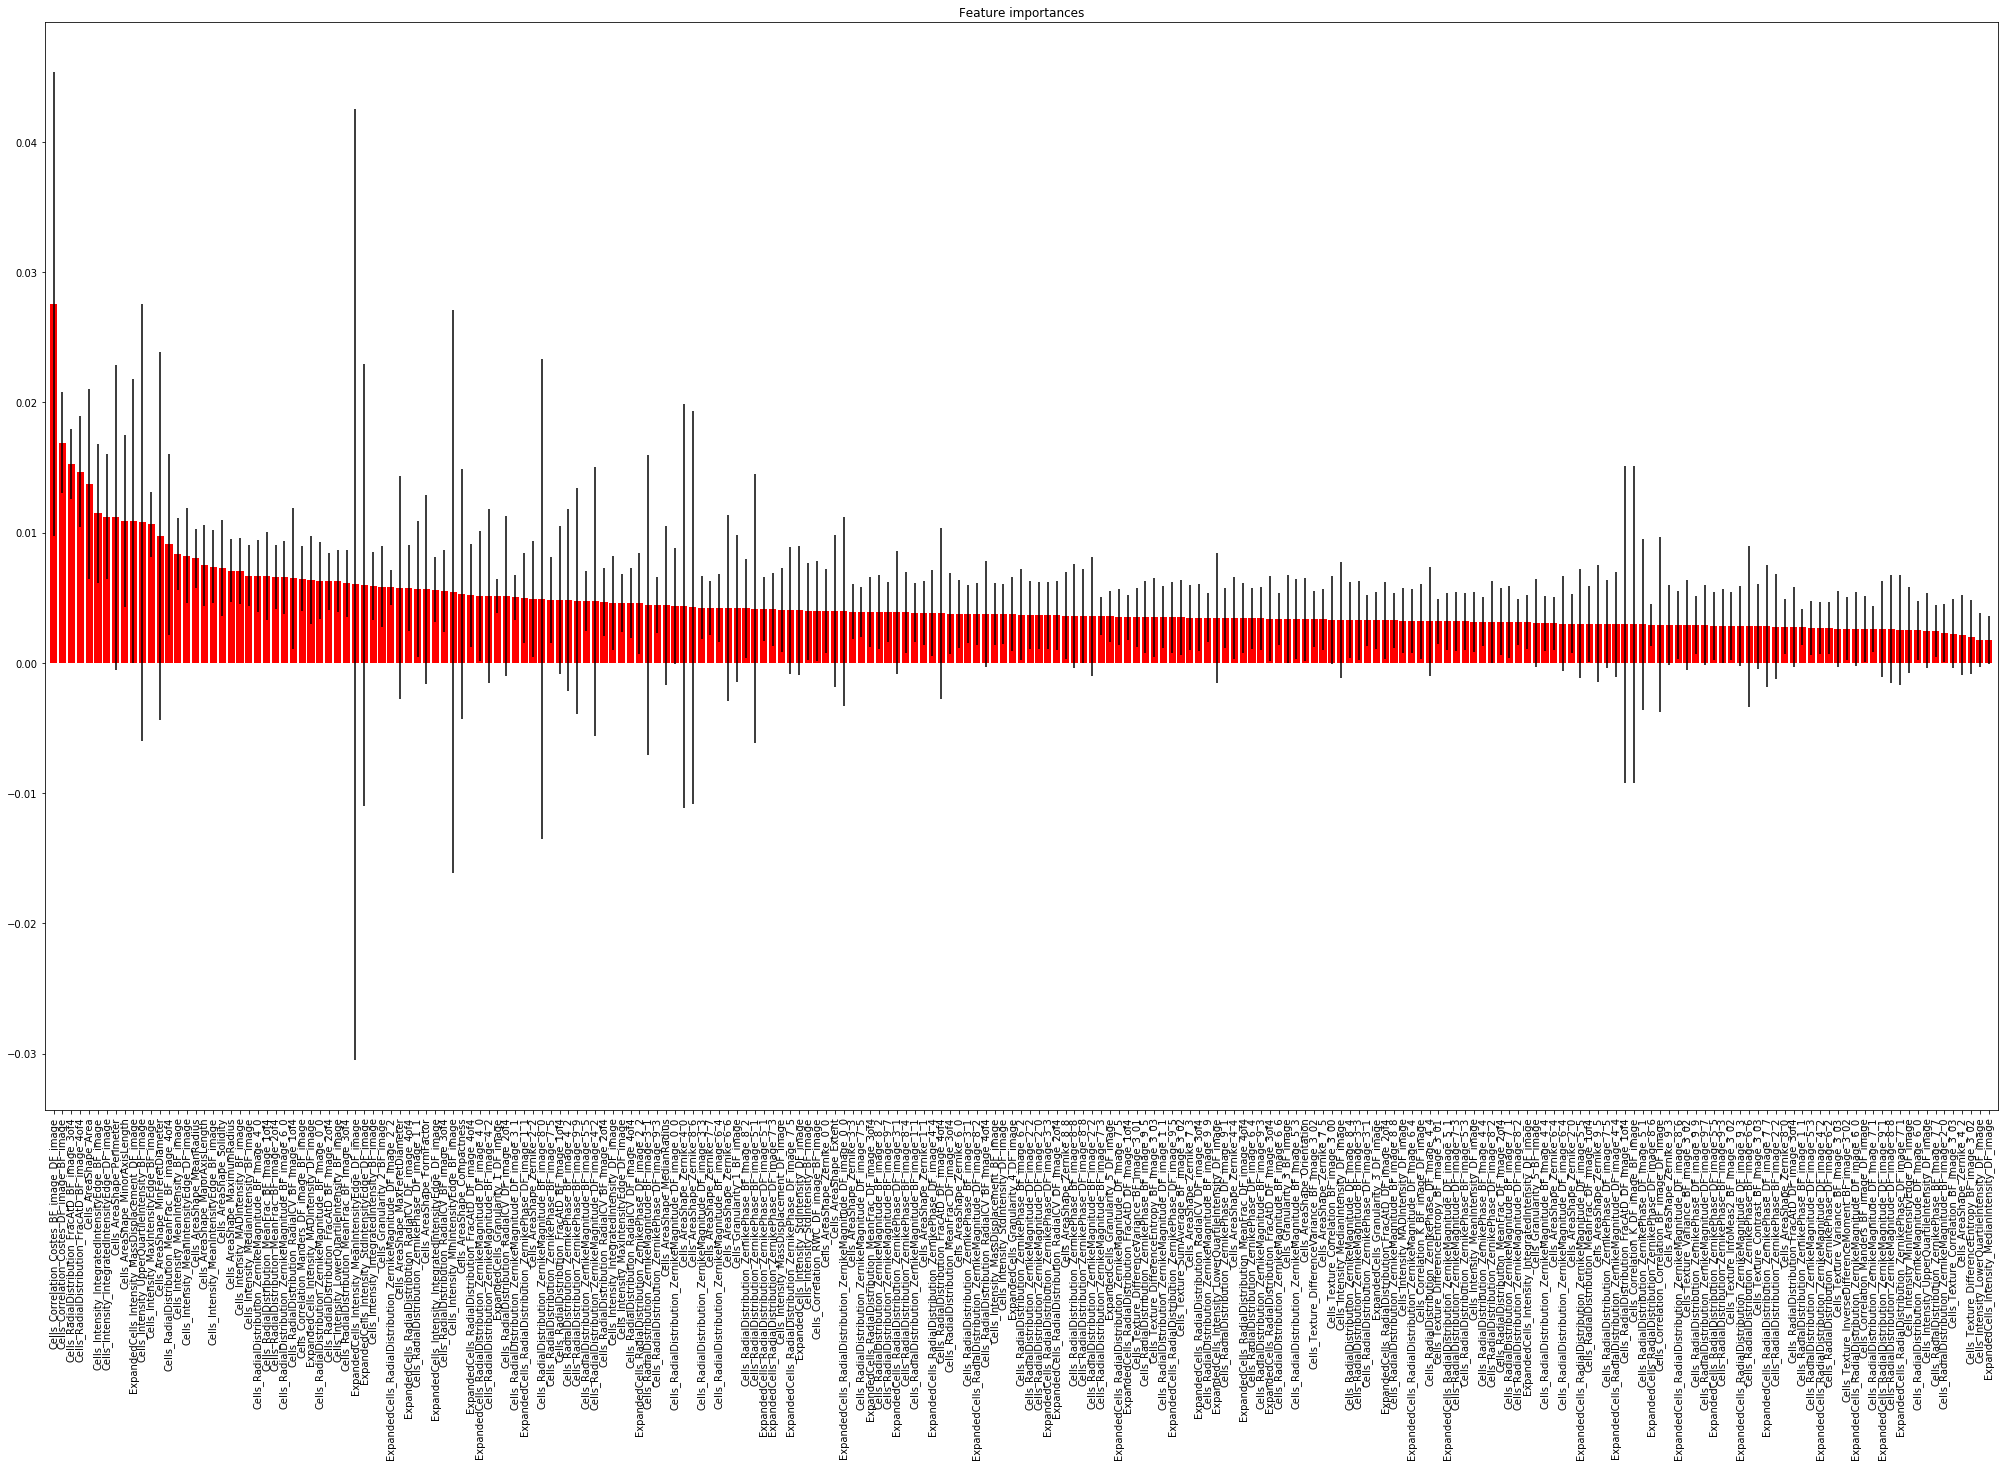

In [3]:
#----- Tree-based feature selection -----#

clf = RandomForestRegressor(n_estimators=20, max_features=2)
clf = clf.fit(objects_train, numeric_labels)
clf.feature_importances_

df1 = objects_train.copy(deep=True) # Make a deep copy of the dataframe
selector = SelectFromModel(clf, prefit=True)
selector.transform(df1)

data_train = objects_train.loc[:,selector.get_support(indices=False)] 
print('After feature selection, data has shape              : ', data_train.shape)

# List of all the feature names
selected_features_names =list(data_train.columns.values)
plot_rank_importance(data_train, numeric_labels, train_directory)

numpy.savetxt( os.path.join(train_directory, 'after_feature_selection_data.txt' ), data_train, delimiter='\t')

#----- To be used as main data on http://projector.tensorflow.org -----#
numpy.savetxt( os.path.join(train_directory, 'after_feature_selection_scaled_data.txt' ), scale(data_train), delimiter='\t')

------------- Preprocessing testing data accordingly -------------

In [4]:
#----- Load testing data -----#
query_objects = database_test.execute("SELECT * From Per_Object")
cols_objects = [column[0] for column in query_objects.description]
objects_test = pandas.DataFrame.from_records(data = query_objects.fetchall(), columns = cols_objects)
print('Original test data has shape (rows, columns)                      : ', objects_test.shape)

query_image = database_test.execute("SELECT * From Per_Image")
cols_image = [column[0] for column in query_image.description]
images_test = pandas.DataFrame.from_records(data = query_image.fetchall(), columns = cols_image)

variables_image = [col for col in images_test.columns if col.startswith(('ImageNumber','Image_Metadata_folder'))]
selected_var_images_test = pandas.DataFrame(images_test, columns=variables_image)


#----- Apply feature selection rules learned from training data on test data -----#
selected_var_objects_test = pandas.DataFrame(objects_test, columns=[selected_features_names + ["ImageNumber"]])


#----- Remove any row that has NA -----#
selected_var_objects_test = selected_var_objects_test.dropna()


#----- Create labels for test data -----#
merged_table_test = pandas.merge(selected_var_images_test, selected_var_objects_test, on=['ImageNumber'], how='inner')
test_labels = list(merged_table_test.Image_Metadata_folder)
# Save labels, to be used as "metadata" on http://projector.tensorflow.org
save_metadata( os.path.join(test_directory, 'test_labels.tsv'), test_labels )


data_test = selected_var_objects_test.drop([selected_var_objects_test.columns[-1]], axis=1)
print('After removing NA rows and feature selection, test data has shape : ', data_test.shape)


numpy.savetxt( os.path.join(test_directory, 'after_feature_selection_testdata.txt' ), data_test, delimiter='\t')
#----- To be used as main data on http://projector.tensorflow.org -----#
numpy.savetxt( os.path.join(test_directory, 'after_feature_selection_scaled_testdata.txt' ), scale(data_test), delimiter='\t')

Original test data has shape (rows, columns)                      :  (4500, 512)
After removing NA rows and feature selection, test data has shape :  (4495, 219)


# ------------- Machine learning -------------

Training machine learning model                      :  NaiveBayes
Normalized confusion matrix
[[ 0.857  0.143  0.     0.     0.     0.     0.   ]
 [ 0.018  0.713  0.204  0.021  0.029  0.009  0.006]
 [ 0.     0.012  0.543  0.18   0.204  0.027  0.034]
 [ 0.     0.015  0.262  0.308  0.231  0.077  0.108]
 [ 0.     0.024  0.158  0.313  0.317  0.055  0.133]
 [ 0.     0.022  0.024  0.138  0.098  0.284  0.433]
 [ 0.     0.     0.     0.143  0.     0.286  0.571]]


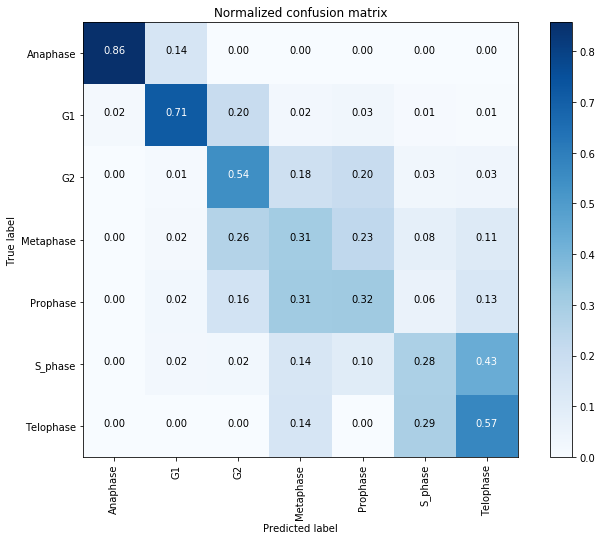

Training machine learning model                      :  RandomForest
Normalized confusion matrix
[[ 0.5    0.5    0.     0.     0.     0.     0.   ]
 [ 0.002  0.734  0.228  0.001  0.018  0.017  0.   ]
 [ 0.     0.086  0.697  0.001  0.14   0.076  0.   ]
 [ 0.     0.046  0.262  0.     0.477  0.215  0.   ]
 [ 0.     0.043  0.322  0.002  0.435  0.198  0.   ]
 [ 0.     0.02   0.071  0.001  0.096  0.811  0.001]
 [ 0.     0.     0.     0.     0.095  0.905  0.   ]]


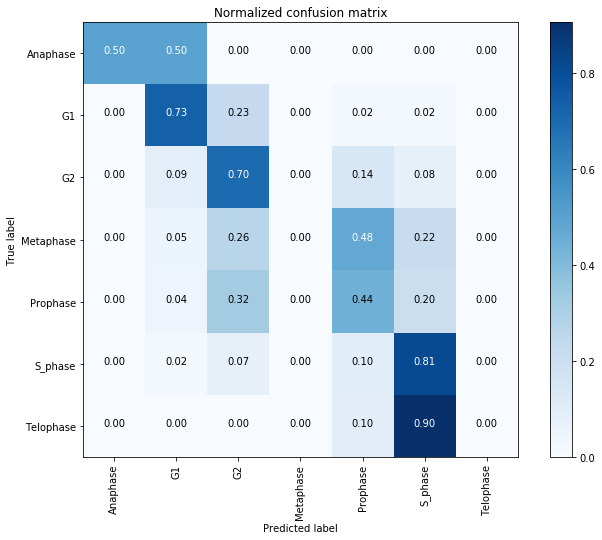

In [5]:
#----- Train models that were previously defined by users -----#

for name, model in names_classifiers:
    print('Training machine learning model                      : ', name)

    #----- Train -----#
    model.fit( scale(data_train), ground_truth)   
    
    #----- 10-fold cross validation -----#
    y_pred = sklearn.model_selection.cross_val_predict(model, scale(data_train), ground_truth, cv=10)
    cm = confusion_matrix(ground_truth, y_pred, labels = sorted(list(set(ground_truth))))
        
    #----- plot, print and save train results -----#
    plot_recall(name, cm, train_directory)
    plot_confusion_matrix(cm, train_directory, name, 
                          classes=sorted(list(set(ground_truth))), 
                          normalize=True,title='Normalized confusion matrix')
        
    #----- save the model to disk -----#
    filename = os.path.join(train_directory, name) + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))   

------------- Inference -------------

Testing machine learning model                      :  NaiveBayes


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [  0.   1.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


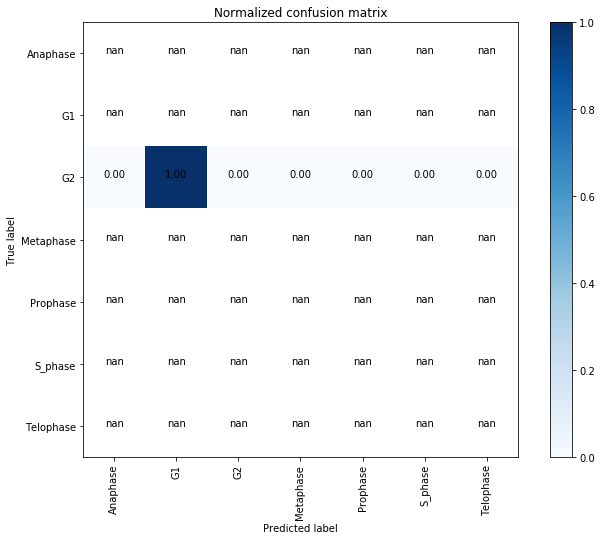

Testing machine learning model                      :  RandomForest
Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [  0.   1.   0.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


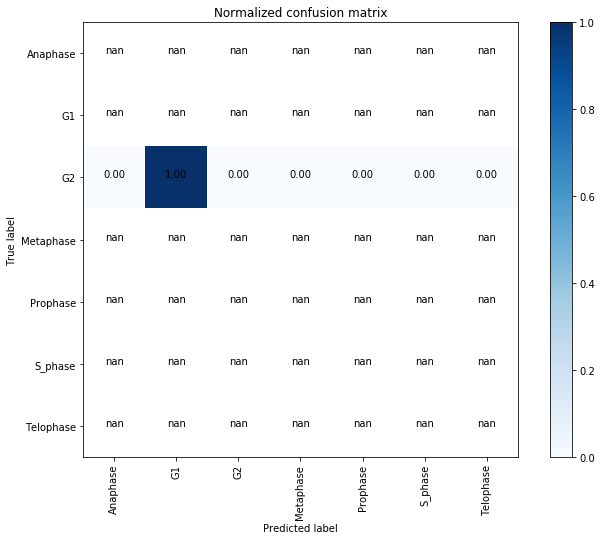

In [6]:
#----- Test the trained models on test data (inference) -----#

for name, model in names_classifiers:
    print('Testing machine learning model                      : ', name)

    #----- load the trained model from disk -----#
    filename = os.path.join(train_directory, name) + '_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))

    #----- Test -----#
    predictions = loaded_model.predict(data_test)

    cm_test = confusion_matrix(test_labels, predictions, labels = sorted(list(set(ground_truth))))
    
    #----- plot, print and save the test results -----#
    plot_recall(name, cm_test, train_directory)
    plot_confusion_matrix(cm_test, test_directory, name, 
                          classes=sorted(list(set(ground_truth))), 
                          normalize=True,title='Normalized confusion matrix')


Performing recursive feature elimination             :  RandomForest_recursive
Normalized confusion matrix
[[ 1.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.993  0.004  0.     0.     0.002  0.   ]
 [ 0.     0.002  0.994  0.     0.002  0.001  0.   ]
 [ 0.     0.     0.077  0.877  0.046  0.     0.   ]
 [ 0.     0.     0.007  0.     0.986  0.007  0.   ]
 [ 0.     0.     0.001  0.     0.004  0.994  0.   ]
 [ 0.     0.     0.     0.     0.     0.238  0.762]]


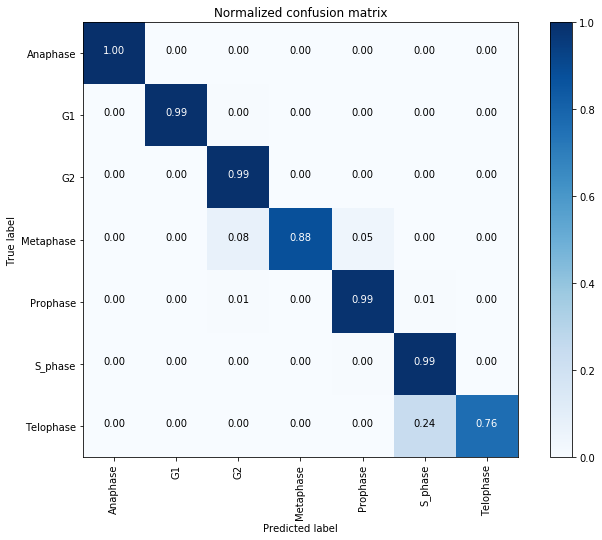

After recursive feature elimination, data has shape  :  (3363, 19)


In [7]:
#----- Feature importance ranking -----#

for name, model in [('RandomForest_recursive', RandomForestClassifier())]:
    print('Performing recursive feature elimination             : ', name)

    selector = RFECV(model, step=20, cv=10)
    selector = selector.fit(data_train, ground_truth)
    
     
    y_pred = selector.predict(data_train)
    cm = confusion_matrix(ground_truth, y_pred, labels = sorted(list(set(ground_truth))))

        
    #----- plot, print and save train results -----#
    plot_recall(name, cm, train_directory)
    plot_confusion_matrix(cm, train_directory, name, 
                          classes=sorted(list(set(ground_truth))), 
                          normalize=True,title='Normalized confusion matrix')
        
    #----- save the model to disk -----#
    filename = os.path.join(train_directory, name) + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))       
    
    
       
    selected_features_indices = selector.get_support(True)
    selected_features = []
    for i in selected_features_indices:
        selected_features.append(selected_features_names[i])
    
    output_file_name = name + '_after_RFE.txt'
    output_file = open(os.path.join(train_directory, output_file_name), 'w+')
    output_file.write(str(selected_features))
    output_file.close()


#----- To be used as main data on http://projector.tensorflow.org -----#

rfe_data = pandas.DataFrame(data_train, columns=selected_features)
print('After recursive feature elimination, data has shape  : ', rfe_data.shape)

numpy.savetxt( os.path.join(train_directory, 'after_recursive_feature_selection_train_data.txt' ),
              rfe_data, delimiter='\t'
             )
numpy.savetxt( os.path.join(train_directory, 'after_recursive_feature_selection_scaled_train_data.txt' ),
              scale(rfe_data), delimiter='\t'
             )